<a href="https://colab.research.google.com/github/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L17/1_VAE_mnist_sigmoid_mse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install watermark
!git clone https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21.git
import sys, os
sys.path.append("/content/stat453-deep-learning-ss21/L17")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.2 MB/s 
Cloning into 'stat453-deep-learning-ss21'...
remote: Enumerating objects: 1507, done.
remote: Counting objects: 100% (457/457), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 1507 (delta 362), reused 359 (delta 304), pack-reused 1050
Receiving objects: 100% (1507/1507), 117.84 MiB | 20.90 MiB/s, done.
Resolving deltas: 100% (466/466), done.


STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Convolutional Variational Autoencoder for MNIST

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

torch: 1.13.0+cu116



## Imports

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [4]:
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [5]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50
NUM_CLASSES = 10

Device: cuda:0


In [6]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [7]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [8]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [12]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        # z_mu.size() is [256, 2], z_log_var.size() is [256, 2]
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        # z.size() is [256, 2]
        return z
        
    def forward(self, x):
        # x.size() is [256, 1, 28, 28]
        x = self.encoder(x)
        # x.size() is [256, 3136]
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        # z_mean.size() is [256, 2], z_log_var.size() is [256, 2]
        encoded = self.reparameterize(z_mean, z_log_var)
        # encoded.size() is [256, 2]
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [13]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [15]:
for batch_idx, (features, _) in enumerate(train_loader):
  features = features.to(DEVICE)
  encoded, z_mean, z_log_var, decoded = model(features)
  break

## Training

In [16]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/050 | Batch 0000/0234 | Loss: 183.7949
Epoch: 001/050 | Batch 0050/0234 | Loss: 56.2281
Epoch: 001/050 | Batch 0100/0234 | Loss: 53.1097
Epoch: 001/050 | Batch 0150/0234 | Loss: 51.2185
Epoch: 001/050 | Batch 0200/0234 | Loss: 48.9784
Time elapsed: 0.55 min
Epoch: 002/050 | Batch 0000/0234 | Loss: 47.5530
Epoch: 002/050 | Batch 0050/0234 | Loss: 46.2130
Epoch: 002/050 | Batch 0100/0234 | Loss: 43.1536
Epoch: 002/050 | Batch 0150/0234 | Loss: 44.8480
Epoch: 002/050 | Batch 0200/0234 | Loss: 43.6637
Time elapsed: 1.08 min
Epoch: 003/050 | Batch 0000/0234 | Loss: 43.0322
Epoch: 003/050 | Batch 0050/0234 | Loss: 43.3077
Epoch: 003/050 | Batch 0100/0234 | Loss: 42.5639
Epoch: 003/050 | Batch 0150/0234 | Loss: 40.8661
Epoch: 003/050 | Batch 0200/0234 | Loss: 41.0239
Time elapsed: 1.61 min
Epoch: 004/050 | Batch 0000/0234 | Loss: 41.7062
Epoch: 004/050 | Batch 0050/0234 | Loss: 41.7626
Epoch: 004/050 | Batch 0100/0234 | Loss: 40.3795
Epoch: 004/050 | Batch 0150/0234 | Loss: 41.2932

## Evaluation

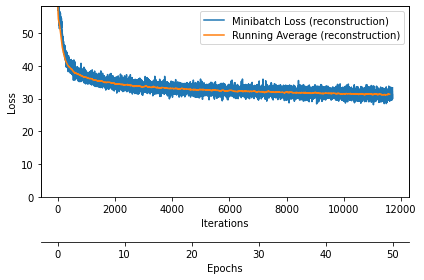

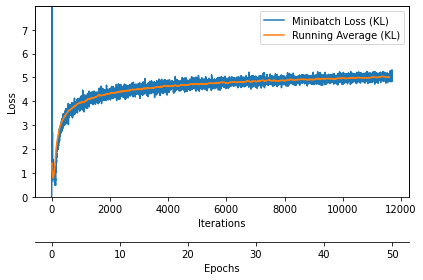

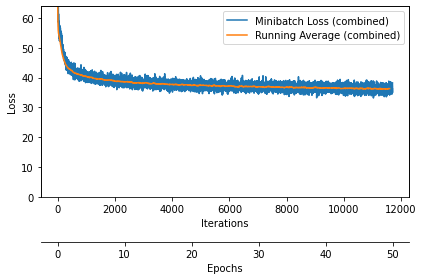

In [17]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

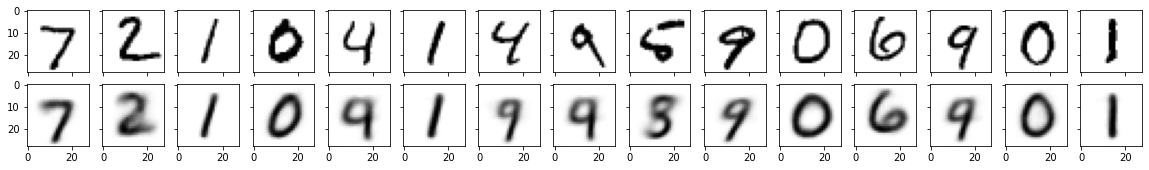

In [19]:
plot_generated_images(data_loader=test_loader, model=model, device=DEVICE, modeltype='VAE')           

encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.Size([256, 3136])
encoding_fn() encoded.size() torch.Size([256, 2])
encoding_fn() x.size() torch.S

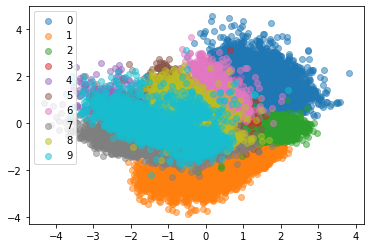

In [20]:
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn, 
    device=DEVICE)

plt.legend()
plt.show()

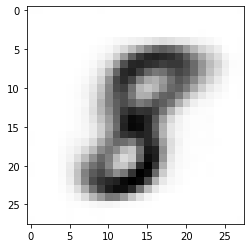

In [21]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

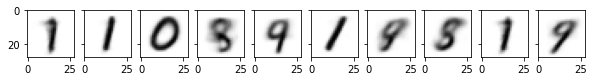

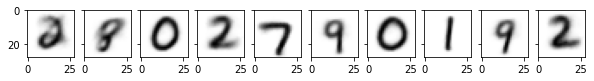

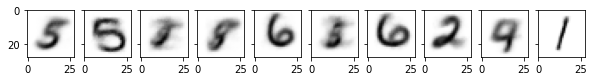

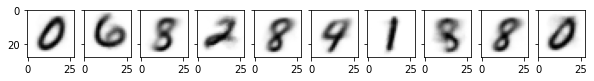

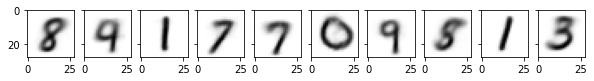

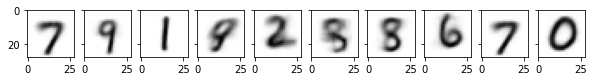

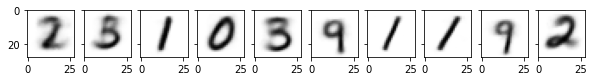

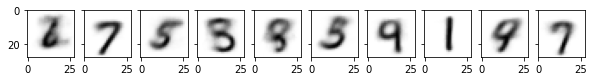

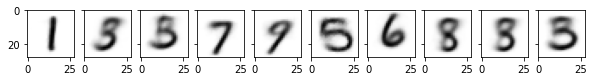

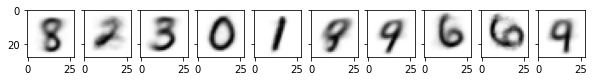

In [24]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=2)
    plt.show()